In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import tqdm

verbose = True

In [48]:
def load_image_from_path(path):
    """
    Decode a jpg image from the string filepath

    :param path: Path to image
    :return: 3D image tensor
    """
    raw_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw_img, channels=3)
    img = tf.image.convert_image_dtype(img, 'float32') # pre-normalises to 0,1
    
    # # make images black and white
    # img = tf.image.rgb_to_grayscale(img)
    
    return img.numpy()

In [49]:
PATH_TO_DATA = "data/final_64x64_proc"

train_filelist = glob.glob(os.path.join(PATH_TO_DATA, "TRAIN", "*.jpg"))
val_filelist = glob.glob(os.path.join(PATH_TO_DATA, "VAL", "*.jpg"))

In [50]:
train_data = np.array([load_image_from_path(f) for f in tqdm.tqdm(train_filelist)])
val_data = np.array([load_image_from_path(f) for f in tqdm.tqdm(val_filelist)])

100%|██████████| 500/500 [00:00<00:00, 1863.27it/s]


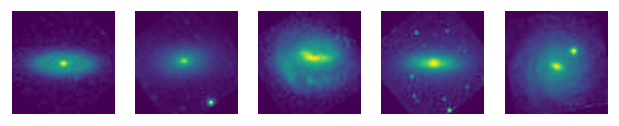

In [51]:
# plot some examples
N_EXAMPLES = 5
random_idx_seed = np.random.randint(0, len(val_data), 5)

fig, ax = plt.subplots(1, 5, dpi=120)

for i, idx in enumerate(random_idx_seed):
  ax[i].imshow(train_data[idx], interpolation='lanczos')
  ax[i].axis("off")

In [52]:
def build_autoencoder(input_shape, code_dim, verbose=True):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(code_dim, name='bottleneck'))

  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.UpSampling2D(size=(4,4), interpolation='bilinear'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same'))
  return model

In [53]:
autoenc = build_autoencoder((64, 64, 3), 16, verbose=False)

In [54]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss = tf.keras.losses.MeanSquaredError()
autoenc.compile(optimizer=opt, loss=loss, metrics=["mae"])

In [55]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
history = autoenc.fit(x=train_data, y=train_data, epochs=500, verbose=1, 
                    validation_data=(val_data, val_data), batch_size=16, callbacks=[early_stop,])

Epoch 1/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.1104 - mae: 0.2837 - val_loss: 0.0129 - val_mae: 0.0968
Epoch 2/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0119 - mae: 0.0764 - val_loss: 0.0039 - val_mae: 0.0427
Epoch 3/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 5.8877e-04 - val_mae: 0.0175
Epoch 4/500
285/313 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.9765e-04 - mae: 0.0172

KeyboardInterrupt: 

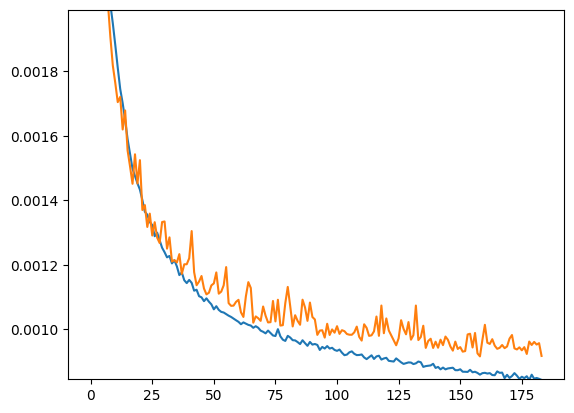

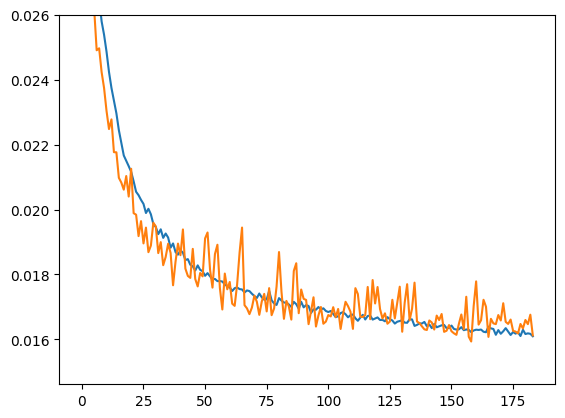

In [47]:
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.ylim(0.9*np.percentile(history.history["val_loss"], 5), 1.1*np.percentile(history.history["val_loss"], 95))
plt.show()

plt.plot(history.epoch, history.history["mae"])
plt.plot(history.epoch, history.history["val_mae"])
plt.ylim(0.9*np.percentile(history.history["val_mae"], 5), 1.1*np.percentile(history.history["val_mae"], 95))
plt.show()

In [ ]:
reproduction = autoenc.predict(val_data)

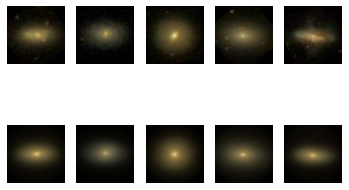

In [ ]:
fig, ax = plt.subplots(2, 5)

random_idx_seed = np.random.randint(0, len(val_data), 5)

for i, val in enumerate(random_idx_seed):
  ax[0][i].imshow(val_data[val])
  ax[0][i].axis("off")
  ax[1][i].imshow(reproduction[val])
  ax[1][i].axis("off")

In [ ]:
autoenc.save("autoenc.h5")